In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow=="2.15.1"

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing instal

In [ ]:
# Cek versi TensorFlow
import tensorflow as tf
print(tf.__version__)

2.15.1


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
# Download dataset
import kagglehub
path = kagglehub.dataset_download("techsash/waste-classification-data")

In [ ]:
# Menentukan lokasi dataset
dataset_path = os.path.join(path, 'DATASET')

# Dataset direktori
train_dir = os.path.join(dataset_path, 'TRAIN')
test_dir = os.path.join(dataset_path, 'TEST')

# Data augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
val_gen = ImageDataGenerator(rescale=1./255)

train_gen = data_gen.flow_from_directory(train_dir, target_size=(224,224), batch_size=128)
validation_gen = val_gen.flow_from_directory(test_dir, target_size=(224,224), batch_size=128)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
# Load base model ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Latih model untuk beberapa epoch pertama dengan base model yang tidak dilatih
history = model.fit(
    train_gen,
    epochs=5,
    validation_data=validation_gen
)


Epoch 1/5
177/177 [==============================] - 366s 2s/step - loss: 1.5335 - accuracy: 0.5982 - val_loss: 0.7399 - val_accuracy: 0.6399
Epoch 2/5
177/177 [==============================] - 351s 2s/step - loss: 0.7147 - accuracy: 0.6196 - val_loss: 0.7049 - val_accuracy: 0.5607
Epoch 3/5
177/177 [==============================] - 350s 2s/step - loss: 0.6813 - accuracy: 0.6322 - val_loss: 0.6724 - val_accuracy: 0.6049
Epoch 4/5
177/177 [==============================] - 352s 2s/step - loss: 0.6714 - accuracy: 0.6333 - val_loss: 0.6718 - val_accuracy: 0.6307
Epoch 5/5
177/177 [==============================] - 351s 2s/step - loss: 0.6647 - accuracy: 0.6290 - val_loss: 0.6911 - val_accuracy: 0.5790


In [ ]:
# Fine-tuning: Buka beberapa lapisan dari base model untuk fine-tuning
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

# Kompilasi ulang model setelah fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=validation_gen,
    callbacks=[early_stopping]
)

Epoch 1/20
177/177 [==============================] - 412s 2s/step - loss: 0.3840 - accuracy: 0.8403 - val_loss: 2.2403 - val_accuracy: 0.4425
Epoch 2/20
177/177 [==============================] - 383s 2s/step - loss: 0.3049 - accuracy: 0.8823 - val_loss: 0.7654 - val_accuracy: 0.6041
Epoch 3/20
177/177 [==============================] - 386s 2s/step - loss: 0.2811 - accuracy: 0.8926 - val_loss: 0.6247 - val_accuracy: 0.7004
Epoch 4/20
177/177 [==============================] - 385s 2s/step - loss: 0.2608 - accuracy: 0.9028 - val_loss: 0.2639 - val_accuracy: 0.9037
Epoch 5/20
177/177 [==============================] - 389s 2s/step - loss: 0.2417 - accuracy: 0.9078 - val_loss: 0.6370 - val_accuracy: 0.7362
Epoch 6/20
177/177 [==============================] - 387s 2s/step - loss: 0.2302 - accuracy: 0.9140 - val_loss: 0.4514 - val_accuracy: 0.8317
Epoch 7/20
177/177 [==============================] - 388s 2s/step - loss: 0.2201 - accuracy: 0.9176 - val_loss: 0.2702 - val_accuracy: 0.9005

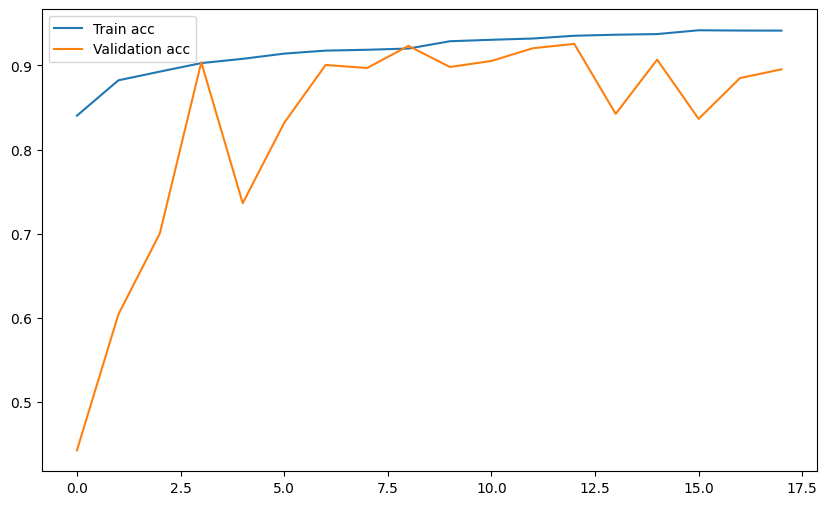

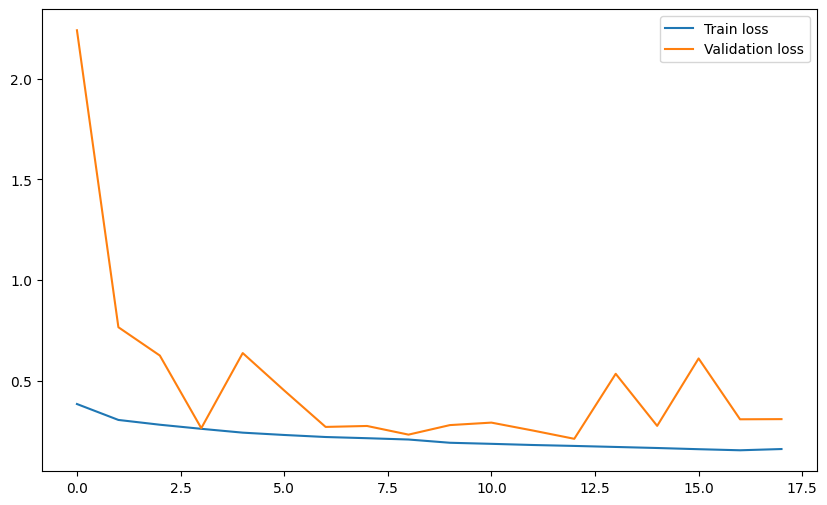

In [ ]:
# Hasil grafik plot
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
# Evaluasi model
evaluation = model.evaluate(validation_gen)
print(f"Final loss: {evaluation[0]}, Final accuracy: {evaluation[1]}")

20/20 [==============================] - 9s 424ms/step - loss: 0.2112 - accuracy: 0.9256
Final loss: 0.21115337312221527, Final accuracy: 0.9255869388580322


In [ ]:
# simpan model
model.save('waste_classification_model.keras')

In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 804.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packagi

2024-12-10 03:40:19.626207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733802019.652739   50594 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733802019.660805   50594 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 5, in <module>
    from tensorflowjs.converters.converter import pip_main
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/__init__.py", line 21, in <module>
    from tensorflowjs.converters

FileNotFoundError: Cannot find file: tfjs_model.zip

In [ ]:
# mengubah model.keras kedalam bentuk json
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model waste_classification_model.keras tfjs_model
!zip -r tfjs_model.zip tfjs_model
from google.colab import files
files.download('tfjs_model.zip')

2024-12-10 03:40:42.745125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733802042.766452   50763 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733802042.773004   50763 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 03:40:42.794390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>